In [1]:
#%matplotlib notebook
import uproot
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import networkx as nx
from itertools import combinations
from hausdorff import hausdorff_distance
import copy
import math
import keras
import glob

/Users/joosep/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


ModuleNotFoundError: No module named 'theano'

In [46]:
Xs_cluster = []
Xs_track = []
ys_cand = []
    
maxclusters = 400
maxtracks = 500
maxcands = 100

for fn in glob.glob("/Users/joosep/Documents/caltech/pfvalidation/out.root"):
    fi = uproot.open(fn)
    tree = fi.get("pftree")
    data = tree.arrays(tree.keys())
    data = {str(k, 'ascii'): v for k, v in data.items()}

    for iev in range(len(tree)):
        cands_pi = np.abs(data["pfcands_pdgid"][iev]) == 211
        pt = data["pfcands_pt"][iev][cands_pi]
        eta = data["pfcands_eta"][iev][cands_pi]
        phi = data["pfcands_phi"][iev][cands_pi]

        Xs_cluster += [np.stack([data["clusters_energy"][iev][:maxclusters],
            data["clusters_x"][iev][:maxclusters],
            data["clusters_y"][iev][:maxclusters],
            data["clusters_z"][iev][:maxclusters]], axis=1)
        ]
        Xs_track += [np.stack([data["tracks_qoverp"][iev][:maxtracks],
            data["tracks_phi"][iev][:maxtracks],
            data["tracks_lambda"][iev][:maxtracks],
            data["tracks_dxy"][iev][:maxtracks],
            data["tracks_dsz"][iev][:maxtracks]], axis=1)]
        ys_cand += [np.stack([
            pt[:maxcands],
            eta[:maxcands],
            phi[:maxcands]], axis=1)]

In [47]:
for i in range(len(Xs_cluster)):
    Xs_cluster[i] = np.pad(Xs_cluster[i], [(0,maxclusters - Xs_cluster[i].shape[0]), (0,0)], mode='constant')

for i in range(len(Xs_track)):
    Xs_track[i] = np.pad(Xs_track[i], [(0,maxtracks - Xs_track[i].shape[0]), (0,0)], mode='constant')

for i in range(len(ys_cand)):
    ys_cand[i] = np.pad(ys_cand[i], [(0,maxcands - ys_cand[i].shape[0]), (0,0)], mode='constant')

Xs1 = np.stack(Xs_cluster, axis=0)
Xs2 = np.stack(Xs_track, axis=0)

ys = np.stack(ys_cand, axis=0)

In [48]:
Xs1 = Xs1.reshape((Xs1.shape[0], Xs1.shape[1]*Xs1.shape[2]))
m1 = Xs1.mean(axis=0)
Xs1 -= m1
s1 = Xs1.std(axis=0)
Xs1 /= s1

In [49]:
Xs2 = Xs2.reshape((Xs2.shape[0], Xs2.shape[1]*Xs2.shape[2]))
m2 = Xs2.mean(axis=0)
Xs2 -= m2
s2 = Xs2.std(axis=0)
Xs2 /= s2

In [50]:
ys = ys.reshape((ys.shape[0], ys.shape[1]*ys.shape[2]))
m3 = ys.mean(axis=0)
ys -= m3
s3 = ys.std(axis=0)
ys /= s3

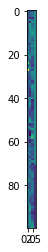

In [142]:
plt.imshow(Xs1[0].reshape(400, 4)[:100])

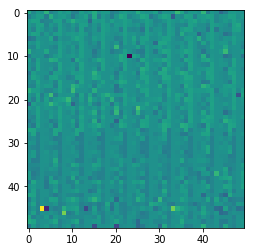

In [134]:
plt.imshow(Xs2[0].reshape(50, 50))

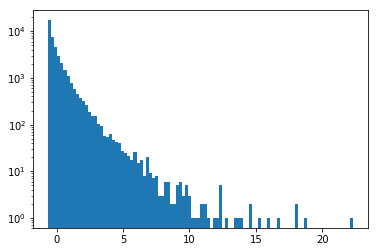

In [51]:
plt.hist(ys[:, 0].flatten(), bins=100)
plt.yscale("log")

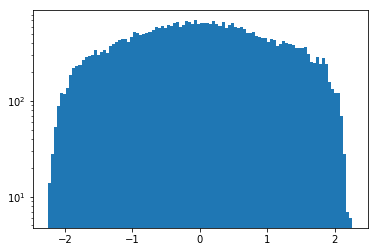

In [52]:
plt.hist(ys[:, 1].flatten(), bins=100)
plt.yscale("log")

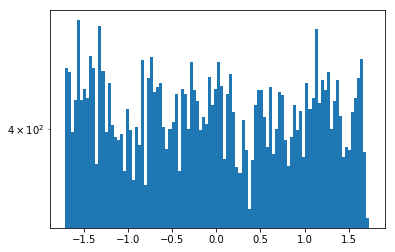

In [53]:
plt.hist(ys[:, 2].flatten(), bins=100)
plt.yscale("log")

In [110]:
from keras.layers import Input, Dense, Flatten, Reshape, Dropout, Concatenate, BatchNormalization, ELU, MaxPooling2D, MaxPooling1D, Conv2D
from keras.models import Model
from keras.optimizers import Adam

inp_clusters = Input(shape=(40, 40, 1))
x1 = Conv2D(10,10)(inp_clusters)
x1 = MaxPooling2D()(x1)
x1 = Conv2D(10,10)(x1)
x1 = MaxPooling2D()(x1)
x1 = Conv2D(10,2)(x1)
x1 = MaxPooling2D()(x1)
x1 = Flatten()(x1)

inp_tracks = Input(shape=(50, 50, 1))
x2 = Conv2D(10,10)(inp_tracks)
x2 = MaxPooling2D()(x2)
x2 = Conv2D(10,10)(x2)
x2 = MaxPooling2D()(x2)
x2 = Conv2D(10,2)(x2)
x2 = MaxPooling2D()(x2)
x2 = Flatten()(x2)

x = Concatenate()([x1,x2])
x = Dense(256)(x)
#x = Dropout(0.2)(x)
x = ELU()(x)

x = Dense(256)(x)
#x = Dropout(0.2)(x)
x = ELU()(x)

x = Dense(256)(x)
#x = Dropout(0.2)(x)
x = ELU()(x)

x = Dense(256)(x)
#x = Dropout(0.2)(x)
x = ELU()(x)

x = Dense(ys.shape[1], activation='linear')(x)
pred = Reshape((20,15))(x)

model = Model(inputs=[inp_clusters, inp_tracks], outputs=pred)
opt = Adam(lr=1e-4)
model.compile(optimizer=opt,
              loss='mse',
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 40, 40, 1)    0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 50, 50, 1)    0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 31, 31, 10)   1010        input_25[0][0]                   
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 41, 41, 10)   1010        input_26[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [111]:
ntrain = 38000

In [112]:
Xs1_2d = Xs1.reshape(Xs1.shape[0], 40, 40, 1)
Xs2_2d = Xs2.reshape(Xs2.shape[0], 50, 50, 1)
ys_2d = ys.reshape(ys.shape[0], 20, 15)

In [113]:
ys_2d.shape

(41100, 20, 15)

In [114]:
ret = model.fit(
    [Xs1_2d[:ntrain], Xs2_2d[:ntrain]], ys_2d[:ntrain],
    validation_data=([Xs1_2d[ntrain:], Xs2_2d[ntrain:]], ys_2d[ntrain:]),
    epochs=20, batch_size=50)

Train on 38000 samples, validate on 3100 samples
Epoch 1/20
38000/38000 [==============================] - 124s 3ms/step - loss: 0.9240 - acc: 0.0695 - val_loss: 0.9078 - val_acc: 0.0743
Epoch 2/20
38000/38000 [==============================] - 123s 3ms/step - loss: 0.8674 - acc: 0.0750 - val_loss: 0.8850 - val_acc: 0.0739
Epoch 3/20
38000/38000 [==============================] - 121s 3ms/step - loss: 0.8478 - acc: 0.0788 - val_loss: 0.8717 - val_acc: 0.0740
Epoch 4/20
38000/38000 [==============================] - 126s 3ms/step - loss: 0.8335 - acc: 0.0817 - val_loss: 0.8652 - val_acc: 0.0824
Epoch 5/20
38000/38000 [==============================] - 123s 3ms/step - loss: 0.8214 - acc: 0.0845 - val_loss: 0.8634 - val_acc: 0.0740
Epoch 6/20
38000/38000 [==============================] - 129s 3ms/step - loss: 0.8090 - acc: 0.0871 - val_loss: 0.8594 - val_acc: 0.0833
Epoch 7/20
38000/38000 [==============================] - 124s 3ms/step - loss: 0.7998 - acc: 0.0881 - val_loss: 0.8583 - v

KeyboardInterrupt: 

In [115]:
plt.plot(ret.history["loss"], marker=".")
plt.plot(ret.history["val_loss"], marker=".")

NameError: name 'ret' is not defined

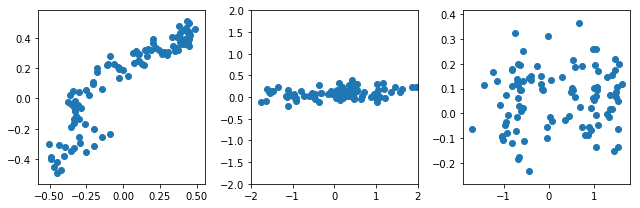

In [106]:
idx = 5

p = model.predict([Xs1[idx:idx+1], Xs2[idx:idx+1]])

plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.scatter(ys[idx, 0:300:3], p[0, 0:300:3])

plt.subplot(1,3,2)
plt.scatter(ys[idx, 1:300:3], p[0, 1:300:3])
plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.subplot(1,3,3)
plt.scatter(ys[idx, 2:300:3], p[0, 2:300:3])

plt.tight_layout()

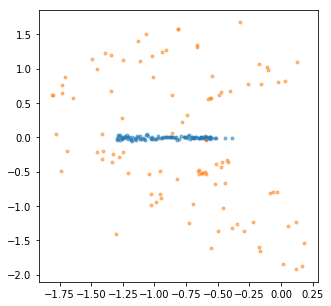

In [76]:
pt = p[0, 0:300:3]
phi = p[0, 2:300:3]
x = pt*np.cos(phi)
y = pt*np.sin(phi)

plt.figure(figsize=(5,5))
plt.scatter(x,y, marker=".", alpha=0.5)

pt2 = ys[idx, 0:300:3]
phi2 = ys[idx, 2:300:3]
x2 = pt2*np.cos(phi2)
y2 = pt2*np.sin(phi2)
plt.scatter(x2, y2, marker=".", alpha=0.5)

In [80]:
def get_index_triu_vector(i, j, vecsize):
    k = j - i - 1
    k += i*vecsize
    missing = int(i*(i+1)/2)
    k -= missing
    return k

In [189]:
fn = "/Users/joosep/Documents/caltech/pfvalidation/out2.root"
fi = uproot.open(fn)
tree = fi.get("pftree")
data = tree.arrays(tree.keys())
data = {str(k, 'ascii'): v for k, v in data.items()}

tree2 = fi.get("linktree")
linkdata = tree2.arrays(tree2.keys())
linkdata = {str(k, 'ascii'): v for k, v in linkdata.items()}

Text(0.5,0,'number of objects')

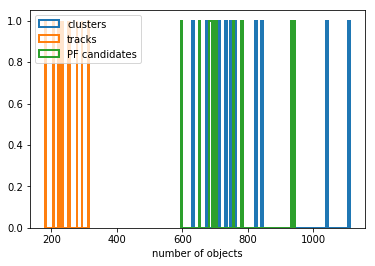

In [190]:
plt.hist(data["nclusters"], bins=100, histtype="step", lw=2, label="clusters");
plt.hist(data["ntracks"], bins=100, histtype="step", lw=2, label="tracks");
plt.hist(data["npfcands"], bins=100, histtype="step", lw=2, label="PF candidates");
plt.legend(loc="best")
plt.xlabel("number of objects")

In [191]:
from collections import Counter

In [192]:
all_blocks_counts_0 = []
all_blocks_counts_1 = []
all_blocks_counts_2 = []
all_blocks_counts_3 = []

for iev in range(len(data["clusters_iblock"])):
    bls = list(data["clusters_iblock"][iev])
    bls2 = list(data["tracks_iblock"][iev])
    bls_counts = sorted([v for k, v in Counter(bls+bls2).items()], reverse=True)
    all_blocks_counts_0 += [bls_counts[0]]
    all_blocks_counts_1 += [bls_counts[1]]
    all_blocks_counts_2 += [bls_counts[2]]
    all_blocks_counts_3 += [bls_counts[3]]

In [193]:
len(np.unique(list(data["clusters_iblock"][iev]) + list(data["tracks_iblock"][iev])))

761

Text(0.5,0,'elements per block')

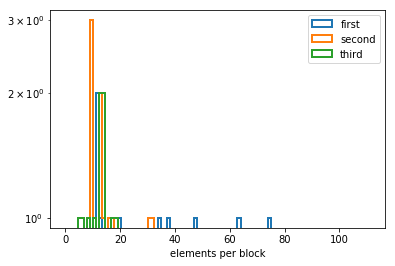

In [194]:
bins = np.linspace(0,1.5*max(all_blocks_counts_0), 100)
plt.hist(all_blocks_counts_0, bins=bins, histtype="step", lw=2, label="first")
plt.hist(all_blocks_counts_1, bins=bins, histtype="step", lw=2, label="second")
plt.hist(all_blocks_counts_2, bins=bins, histtype="step", lw=2, label="third")

plt.yscale("log")
plt.legend(loc="best")
plt.xlabel("elements per block")

In [195]:
pfgraph = nx.Graph()
iev = 2

items_block = {}
node_pos = {}
node_colors = {}
node_sizes = {}
node_types = {}

cluster_colors = {
    3: "blue",
    2: "blue",
    5: "red",
    4: "green",
    8: "orange",
    9: "orange",
    11: "purple",
}

for icluster, iblock in enumerate(data["clusters_iblock"][iev]):
    this = (iblock, data["clusters_ielem"][iev][icluster])
    pfgraph.add_node(this)
    
    node_pos[this] = (data["clusters_eta"][iev][icluster], data["clusters_phi"][iev][icluster])
    tp = data["clusters_type"][iev][icluster]
    node_colors[this] = cluster_colors[tp]
    node_sizes[this] = data["clusters_energy"][iev][icluster]
    if not iblock in items_block.keys():
        items_block[iblock] = []
    items_block[iblock] += [this]
    node_types[this] = tp
    
for itrack, iblock in enumerate(data["tracks_iblock"][iev]):
    this = (iblock, data["tracks_ielem"][iev][itrack])
    pfgraph.add_node(this)
    
    p = abs(data["tracks_qoverp"][iev][itrack])
    eta = data["tracks_outer_eta"][iev][itrack]
    phi = data["tracks_outer_phi"][iev][itrack]
    node_pos[this] = (
        eta, phi
    )
    node_colors[this] = "black"
    node_sizes[this] = 10*p
    node_types[this] = 0

    if not iblock in items_block.keys():
        items_block[iblock] = []
    items_block[iblock] += [this]
    
for iblock, items in items_block.items():
    for comb in combinations(items, 2):
        pfgraph.add_edge(comb[0], comb[1])

Text(0,0.5,'$\\phi$')

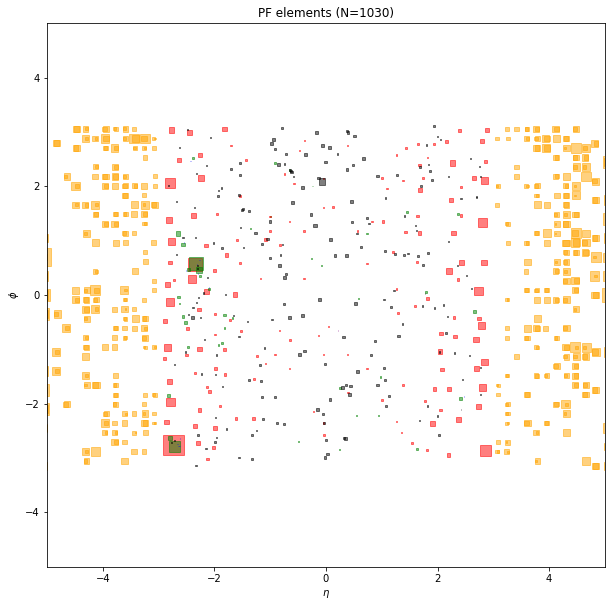

In [196]:
plt.figure(figsize=(10, 10))
plt.xlim(-5,5)
plt.ylim(-5,5)
nx.draw(pfgraph,
        pos=node_pos,
        node_size=[node_sizes[n] for n in pfgraph.nodes],
        node_color=[node_colors[n] for n in pfgraph.nodes],
        edgelist=[],
        node_shape="s",
        alpha=0.5, width=0.05
)
plt.title("PF elements (N={0})".format(len(pfgraph.nodes)))
plt.axis('on')
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

Text(0,0.5,'$\\phi$')

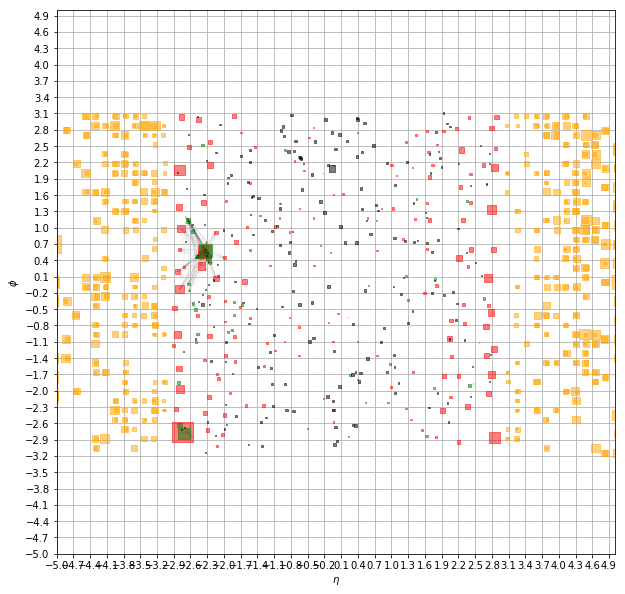

In [197]:
plt.figure(figsize=(10, 10))
plt.xlim(-5,5)
plt.ylim(-5,5)
nx.draw(pfgraph,
        pos=node_pos,
        node_size=[node_sizes[n] for n in pfgraph.nodes],
        node_color=[node_colors[n] for n in pfgraph.nodes],
        node_shape="s",
        alpha=0.5, width=0.01
)
plt.xticks(np.arange(-5,5,0.3))
plt.yticks(np.arange(-5,5,0.3))

plt.grid()
# plt.xlabel("cluster x / scaled track px")
# plt.ylabel("cluster y / scaled track px")
# plt.title("PF elements with blocks")
plt.axis('on')
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

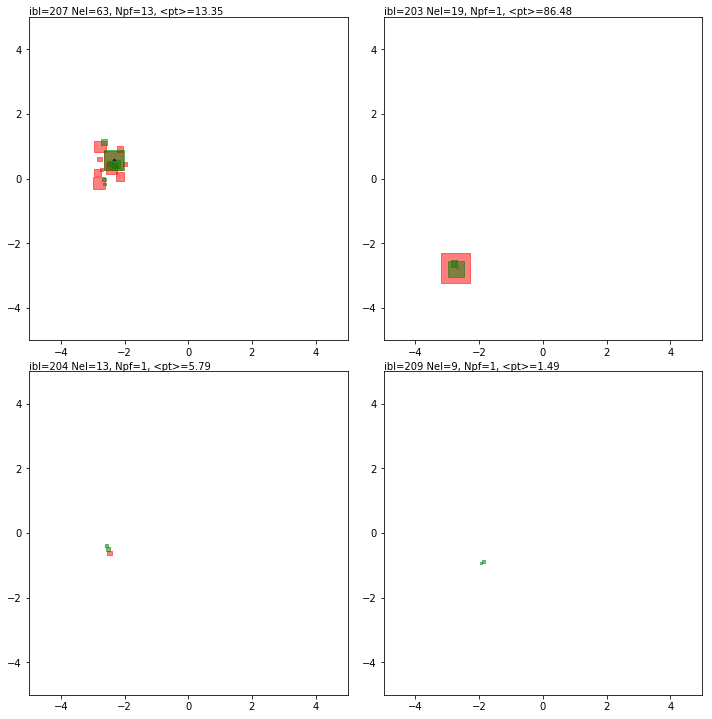

In [198]:
biggest_clusters = sorted([
    (k, items_block[k]) for k in items_block.keys()], reverse=True, key=lambda x: len(x[1])
)[:4]

plt.figure(figsize=(10, 10))
iplot = 1

subs = []
for iblock, elems in biggest_clusters:
    nelem = len(elems)
    
    sub = nx.Graph()
    sub.add_nodes_from(items_block[iblock])
    
    n = linkdata["linkdata_nelem"][iev][linkdata["linkdata_iblock"][iev] == iblock]
    ks = linkdata["linkdata_k"][iev][linkdata["linkdata_iblock"][iev] == iblock]
    dists = linkdata["linkdata_distance"][iev][linkdata["linkdata_iblock"][iev] == iblock]
    kdict = {k: i for i, k in enumerate(ks)}

    vecsize = n[0]
    inds = np.triu_indices(n=vecsize, m=vecsize, k=0.1)
    inds2 = [get_index_triu_vector(i, j, vecsize) for i, j in zip(inds[0], inds[1])]
    for i, ind2 in enumerate(inds2):
        if ind2 in kdict.keys():
            idx_triu_i = inds[0][i]
            idx_triu_j = inds[1][i]
            if idx_triu_j > idx_triu_i:
                tmp = idx_triu_i
                idx_triu_i = idx_triu_j
                idx_triu_j = tmp
            u = (iblock, idx_triu_i)
            v = (iblock, idx_triu_j)
            if u in sub.nodes and v in sub.nodes:
                sub.add_edge(u, v, weight=dists[kdict[ind2]])
    subs += [sub]
    
    ax = plt.subplot(2,2,iplot)

    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    nx.draw(sub,
            pos=node_pos,
            node_size=[2*node_sizes[n] for n in sub.nodes],
            node_color=[node_colors[n] for n in sub.nodes],
            node_shape="s",
            alpha=0.5, width=0.05, ax=ax
    )
    
    pfcand_inds = (data["pfcands_iblock"][iev] == iblock)
    pf_pt = data["pfcands_pt"][iev][pfcand_inds]
    pf_phi = data["pfcands_phi"][iev][pfcand_inds]
    
    plt.text(0.0, 1.0,
        "ibl={0} Nel={1}, Npf={2}, <pt>={3:.2f}".format(
            iblock, nelem, len(pf_pt), np.mean(pf_pt)),
            transform=ax.transAxes, verticalalignment="bottom")
#     pf_x = 5*pf_pt * np.cos(pf_phi)
#     pf_y = 5*pf_pt * np.sin(pf_phi)
    
#     for ipf in range(len(pf_x)):
#         plt.plot([0, pf_x[ipf]], [0, pf_y[ipf]], color="blue")
    plt.axis('on')
    iplot += 1
    
plt.tight_layout()

Text(0.5,0,'$\\phi$')

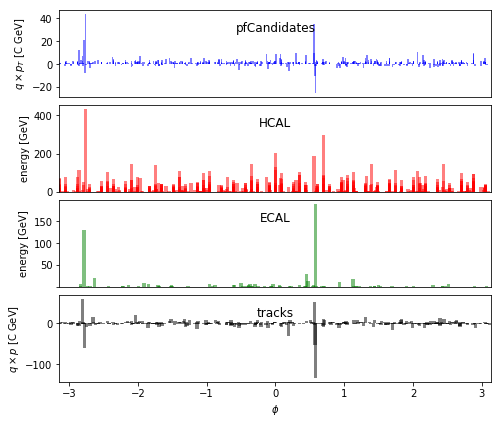

In [161]:
plt.figure(figsize=(6,6))

barwidth = 0.05
axheight = 0.2
axgap = 0.02

cl_ecal = data["clusters_type"][iev] == 4
cl_hcal = data["clusters_type"][iev] >= 5

#cl_hf = data["clusters_type"][iev] >= 8

x = data["clusters_x"][iev]
y = data["clusters_y"][iev]

ax1 = plt.axes([0, 0, 1, axheight])
ax1.bar(data["tracks_phi"][iev], 1.0/data["tracks_qoverp"][iev], width=barwidth, color="black", alpha=0.5)
ax1.set_ylabel(r"$q \times p$ [C GeV]")
ax1.set_xlim(-math.pi, math.pi)
yticks = ax1.yaxis.get_major_ticks()
yticks[0].label1.set_visible(False)
ax1.set_title("tracks", y=0.8, verticalalignment="top")

ax2 = plt.axes([0, 1*(axheight + axgap), 1,axheight])
ax2.bar(np.arctan2(y, x)[cl_ecal], data["clusters_energy"][iev][cl_ecal], width=barwidth, color="green", alpha=0.5)
ax2.set_xticks([])
ax2.set_xlim(-math.pi, math.pi)
yticks = ax2.yaxis.get_major_ticks()
yticks[0].label1.set_visible(False)
ax2.set_ylabel(r"energy [GeV]")
ax2.set_title("ECAL", y=0.8, verticalalignment="top")

ax3 = plt.axes([0,2*(axheight + axgap), 1, axheight])
ax3.bar(np.arctan2(y, x)[cl_hcal], data["clusters_energy"][iev][cl_hcal], width=barwidth, color="red", alpha=0.5)
ax3.set_xticks([])
ax3.set_xlabel("")
ax3.set_xlim(-math.pi, math.pi)
ax3.set_ylabel(r"energy [GeV]")
ax3.set_title("HCAL", y=0.8, verticalalignment="top")

ax4 = plt.axes([0,3*(axheight + axgap), 1.0, axheight])
ax4.bar(data["pfcands_phi"][iev], np.sign(data["pfcands_pdgid"][iev])*data["pfcands_pt"][iev], width=barwidth/2, color="blue", alpha=0.5)
ax4.set_xticks([])
ax4.set_xlabel("")
ax4.set_xlim(-math.pi, math.pi)
ax4.set_ylabel(r"$q \times p_T$ [C GeV]")
ax4.set_title("pfCandidates", y=0.8, verticalalignment="top")


ax1.set_xlabel(r"$\phi$")

In [162]:
hcal_rechits = []
hcal_tracks = []
ecal_rechits = []
ecal_tracks = []
for line in open("/Users/joosep/Documents/caltech/pfvalidation/x").readlines():
    li = line.strip()
    spl = li.split()
    if len(spl)>0:
        tp = spl[0]
        i = int(spl[1])
        eta = float(spl[2])
        phi = float(spl[3])
        
        if tp == "hcal_track":
            hcal_tracks += [(i, eta, phi)]
        elif tp == "hcal_rechit":
            hcal_rechits += [(i, eta, phi)]
        elif tp == "ecal_track":
            ecal_tracks += [(i, eta, phi)]
        elif tp == "ecal_rechit":
            ecal_rechits += [(i, eta, phi)]

In [163]:
def partition(lst):
    inds = []
    for i in range(len(lst)-1):
        if lst[i][0] >= lst[i+1][0]:
            inds += [i]
    return inds

In [164]:
inds1 = partition(hcal_rechits)
inds2 = partition(hcal_tracks)

inds3 = partition(ecal_rechits)
inds4 = partition(ecal_tracks)

/Users/joosep/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


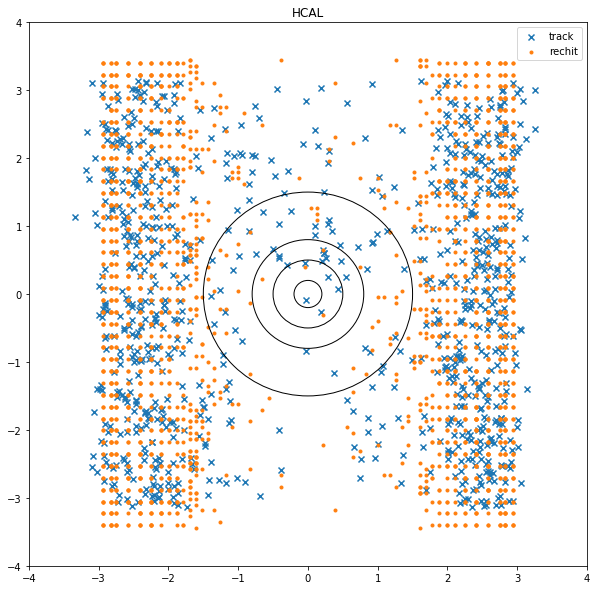

In [165]:
plt.figure(figsize=(10,10))

plt.xlim(-4,4)
plt.ylim(-4,4)
ax = plt.axes()

plt.title("HCAL")
plt.scatter([r[1] for r in hcal_tracks[0:inds2[0]]], [r[2] for r in hcal_tracks[0:inds2[0]]], marker="x", label="track")
plt.scatter([r[1] for r in hcal_rechits[0:inds1[0]]], [r[2] for r in hcal_rechits[0:inds1[0]]], marker=".", label="rechit")

c = plt.Circle([0,0], 0.2, lw=1, fill=None)
ax.add_patch(c)

c = plt.Circle([0,0], 0.5, lw=1, fill=None)
ax.add_patch(c)

c = plt.Circle([0,0], 0.8, lw=1, fill=None)
ax.add_patch(c)

c = plt.Circle([0,0], 1.5, lw=1, fill=None)
ax.add_patch(c)


plt.legend()

/Users/joosep/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


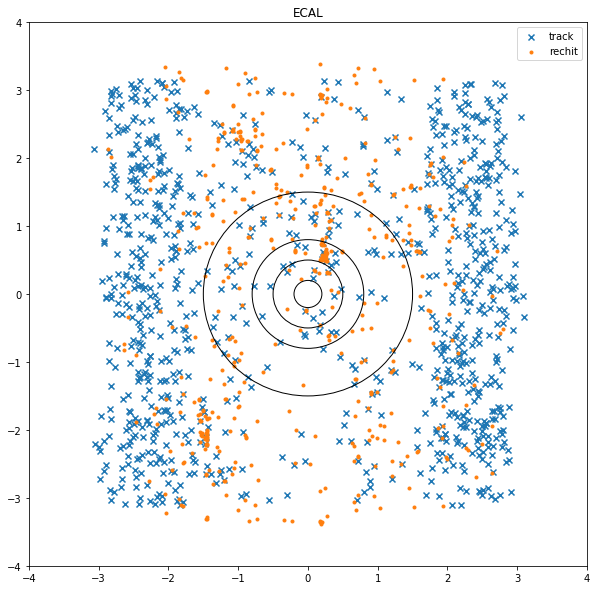

In [166]:
plt.figure(figsize=(10,10))
plt.xlim(-4,4)
plt.ylim(-4,4)
ax = plt.axes()
plt.title("ECAL")
plt.scatter([r[1] for r in ecal_tracks[0:inds4[0]]], [r[2] for r in ecal_tracks[0:inds4[0]]], marker="x", label="track")
plt.scatter([r[1] for r in ecal_rechits[0:inds3[0]]], [r[2] for r in ecal_rechits[0:inds3[0]]], marker=".", label="rechit")

c = plt.Circle([0,0], 0.2, lw=1, fill=None)
ax.add_patch(c)

c = plt.Circle([0,0], 0.5, lw=1, fill=None)
ax.add_patch(c)

c = plt.Circle([0,0], 0.8, lw=1, fill=None)
ax.add_patch(c)

c = plt.Circle([0,0], 1.5, lw=1, fill=None)
ax.add_patch(c)

plt.legend()

/Users/joosep/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


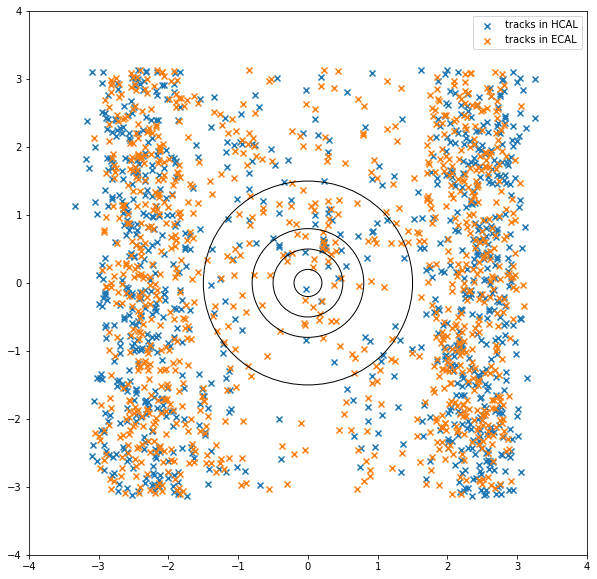

In [69]:
plt.figure(figsize=(10,10))
plt.xlim(-4,4)
plt.ylim(-4,4)

ax = plt.axes()
plt.scatter([r[1] for r in hcal_tracks[0:inds2[0]]], [r[2] for r in hcal_tracks[0:inds2[0]]], marker="x", label="tracks in HCAL")
plt.scatter([r[1] for r in ecal_tracks[0:inds4[0]]], [r[2] for r in ecal_tracks[0:inds4[0]]], marker="x", label="tracks in ECAL")

c = plt.Circle([0,0], 0.2, lw=1, fill=None)
ax.add_patch(c)

c = plt.Circle([0,0], 0.5, lw=1, fill=None)
ax.add_patch(c)

c = plt.Circle([0,0], 0.8, lw=1, fill=None)
ax.add_patch(c)

c = plt.Circle([0,0], 1.5, lw=1, fill=None)
ax.add_patch(c)

plt.legend()